In [1]:
# Allows processes to work with macOS
from sys import platform
if platform == 'darwin':
    import multiprocessing as mp
    mp.set_start_method("fork")

In [78]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 16}
matplotlib.rc('font', **font)


from csr2d.core2 import psi_s, psi_x0, Es_case_B, Fx_case_B, Fx_case_B_Chris
#from csr2d.kick2 import green_meshes_no_phi
from csr2d.convolution import fftconvolve2

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)


from csr2d.core2 import psi_s, psi_x0, Es_case_B, Fx_case_B, Fx_case_B_Chris
#from csr2d.kick2 import green_meshes_no_phi
from csr2d.convolution import fftconvolve2

from csr2d.central_difference import central_difference_z

import time

import concurrent.futures as cf

from scipy import integrate

import tanh_sinh


import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Chris's parameters

In [4]:
gamma = 500
rho = 1.0 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

sigma_x  = 10e-6
sigma_z  = 10e-6

In [5]:
psi_s(-2*sigma_z, 2*sigma_x, beta)

0.4999831878567732

In [6]:
Fx_case_B(0,1e-9,beta)

-31269.421255070163

In [7]:
Fx_case_B_Chris(0,1e-9,beta)

-1.284371234971045

## code

In [8]:
# Bypassing the beam, use smooth Gaussian distribution

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

In [9]:
nz = 101
nx = 101


zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')

lambda_grid_filtered = lamb_2d(zm,xm)
lambda_grid_filtered_prime = lamb_2d_prime(zm,xm)

dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

#psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes_no_phi(nz, nx, dz, dx, rho=rho, beta=beta)  

dxp = dx/rho
dzp = dz/2/rho

# Double-sized array for convolution with the density
zvec2 = np.arange(-nz+1,nz+1,1)*dzp # center = 0 is at [nz-1]
xvec2 = np.arange(-nx+1,nx+1,1)*dxp # center = 0 is at [nx-1]
zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")


psi_s_grid = psi_s(zm2, xm2, beta) # Numba routines!
psi_x_grid = psi_x0(zm2, xm2, beta, abs(dxp)) # Will average around 0

Es_case_B_grid = Es_case_B(zm2, xm2, beta) 
Fx_case_B_grid = Fx_case_B(zm2, xm2, beta) 

#conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

conv_s = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid)[0]
conv_s2 = fftconvolve2(lambda_grid_filtered, Es_case_B_grid)[0]

conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_x_grid)[0]
conv_x2 = fftconvolve2(lambda_grid_filtered, Fx_case_B_grid)[0]


#Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
#Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)



In [10]:
# Want functions in terms of (z,x) only
psi_s_zx = lambda z, x: psi_s(z,x,beta)
psi_x_zx = lambda z, x: psi_x0(z,x,beta,dx)

Es_case_B_zx = lambda z, x: Es_case_B(z,x,beta)
Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)
Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)


def IGF_nquad(func, zval, xval, dz, dx):
    return integrate.nquad(func, [[zval-dz/2, zval+dz/2], [xval-dx/2, xval+dx/2]])[0]

def IGF_nquad_psi_s(z,x):
    return IGF_nquad(psi_s_zx, z, x, dz, dx)

def IGF_nquad_Es_case_B(z,x):
    return IGF_nquad(Es_case_B_zx, z, x, dz, dx)

def IGF_nquad_psi_x(z,x):
    return IGF_nquad(psi_x_zx, z, x, dz, dx)

def IGF_nquad_Fx_case_B(z,x):
    return IGF_nquad(Fx_case_B_zx, z, x, dz, dx)

def IGF_nquad_Fx_case_B_Chris(z,x):
    return IGF_nquad(Fx_case_B_Chris_zx, z, x, dz, dx)

In [11]:
# func must have two arguments only (z,x)

def IGF_test(func, zval, xval, dz, dx):

    def func_z(z):
        return func(z,xval)
    
    if zval != 0:
        #return integrate.nquad(func, [[zval-dz/2, zval+dz/2], [xval-dx/2, xval+dx/2]], opts={'epsabs':1e-12})
        return tanh_sinh.integrate(func_z, zval-dz/2, zval+dz/2, 1e-12, max_steps=30)[0]
    else:
        term1 = tanh_sinh.integrate(func_z, -dz/2, 0, 1e-12, max_steps=30)[0]
        term2 = tanh_sinh.integrate(func_z, 0, dz/2,  1e-12, max_steps=30)[0]
        return term1 + term2
    
#def IGF_tanh_psi_s(zval, xval):
#    return IGF_test(psi_s_zx, zval, xval, dz, dx)

def IGF_tanh_Es_case_B(zval, xval):
    return IGF_test(Es_case_B_zx, zval, xval, dz, dx)

def IGF_tanh_Fx_case_B(zval, xval):
    return IGF_test(Fx_case_B_zx, zval, xval, dz, dx)

In [12]:
xvec2[100]

0.0

In [13]:
IGF_nquad_Fx_case_B_Chris(zvec2[99],xvec2[100])

/Users/wlou/miniconda3/envs/pycsr2d/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:7: RuntimeWarning: divide by zero encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:7: RuntimeWarning: invalid value encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lam

nan

In [14]:
IGF_nquad_psi_s(0,1e-12)

-1.0004276097801737e-10

In [16]:
# Try just the first points in the mesh
t1 = time.time()

temp = map( IGF_nquad_psi_s, zm2.flatten()[0:6], xm2.flatten()[0:6])
psi_s_grid_IGF = np.array(list(temp)).reshape(zm2.flatten()[0:6].shape)
    
t2 = time.time()
print('IGF for psi_s takes:', t2-t1, 'sec')

IGF for psi_s takes: 0.1466350555419922 sec


In [20]:
0.02*40000/60

13.333333333333334

In [21]:
t1 = time.time()

temp = map( IGF_nquad_Es_case_B, zm2.flatten(), xm2.flatten())
Es_case_B_grid_IGF = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Es takes:', t2-t1, 'sec')

/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:5: RuntimeWarning: divide by zero encountered in Es_case_B
  Es_case_B_zx = lambda z, x: Es_case_B(z,x,beta)
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:5: RuntimeWarning: invalid value encountered in Es_case_B
  Es_case_B_zx = lambda z, x: Es_case_B(z,x,beta)


IGF for psi_s takes: 150.65373396873474 sec


In [27]:
t1 = time.time()

temp = map( IGF_nquad_Fx_case_B, zm2.flatten(), xm2.flatten())
Fx_case_B_grid_IGF = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Fx takes:', t2-t1, 'sec')

/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:6: RuntimeWarning: divide by zero encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:6: RuntimeWarning: invalid value encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)


IGF for Fx takes: 146.8693699836731 sec


In [28]:
t1 = time.time()

temp = map( IGF_nquad_Fx_case_B_Chris, zm2.flatten(), xm2.flatten())
Fx_case_B_grid_IGF_Chris = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Fx takes:', t2-t1, 'sec')

/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:7: RuntimeWarning: divide by zero encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:7: RuntimeWarning: invalid value encountered in Fx_case_B_Chris
  Fx_case_B_Chris_zx = lambda z, x: Fx_case_B_Chris(z,x,beta)


IGF for Fx takes: 142.99026107788086 sec


In [85]:
t1 = time.time()

temp = map( IGF_nquad_Fx_case_B, zm2.flatten(), xm2.flatten())
Fx_case_B_grid_IGF = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Es takes:', t2-t1, 'sec')

/Users/wlou/miniconda3/envs/pycsr2d/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:6: RuntimeWarning: divide by zero encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:6: RuntimeWarning: invalid value encountered in Fx_case_B
  Fx_case_B_zx = lambda z, x: Fx_case_B(z,x,beta)


IGF for Es takes: 198.80208897590637 sec


In [ ]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=16) as executor:
    temp = executor.map( IGF_nquad_Es_case_B, zm2.flatten(), xm2.flatten())
    Es_case_B_grid_IGF = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Es_case_B takes:', t2-t1, 'sec')

/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:5: RuntimeWarning: divide by zero encountered in Es_case_B
  Es_case_B_zx = lambda z, x: Es_case_B(z,x,beta)
/var/folders/5f/ybh4pqgj3r10ss6gjvk7t3fhnvsf0k/T/ipykernel_64529/1976595473.py:5: RuntimeWarning: invalid value encountered in Es_case_B
  Es_case_B_zx = lambda z, x: Es_case_B(z,x,beta)


KeyboardInterrupt: 

In [ ]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=16) as executor:
    temp = executor.map( IGF_nquad_Fx_case_B, zm2.flatten(), xm2.flatten())
    Fx_case_B_grid_IGF = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Fx_case_B takes:', t2-t1, 'sec')

In [ ]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=16) as executor:
    temp = executor.map( IGF_nquad_Fx_case_B_Chris, zm2.flatten(), xm2.flatten())
    Fx_case_B_grid_IGF_Chris = np.array(list(temp)).reshape(zm2.shape)
    
t2 = time.time()
print('IGF for Fx_case_B takes:', t2-t1, 'sec')

In [19]:
np.where(np.isnan(Fx_case_B_grid_IGF_Chris))

(array([ 99, 101]), array([100, 100]))

In [29]:
def replace_nan(grid):
    return np.where(np.isnan(grid), 0, grid)

In [30]:
Fx_case_B_grid_IGF_Chris_no_nan = replace_nan(Fx_case_B_grid_IGF_Chris)
Fx_case_B_grid_IGF_no_nan = replace_nan(Fx_case_B_grid_IGF)

In [28]:
jaja = np.where(np.isnan(Fx_case_B_grid_IGF), 0, Fx_case_B_grid_IGF)

Text(0.5, 0.92, '$W_x$ benchmarking')

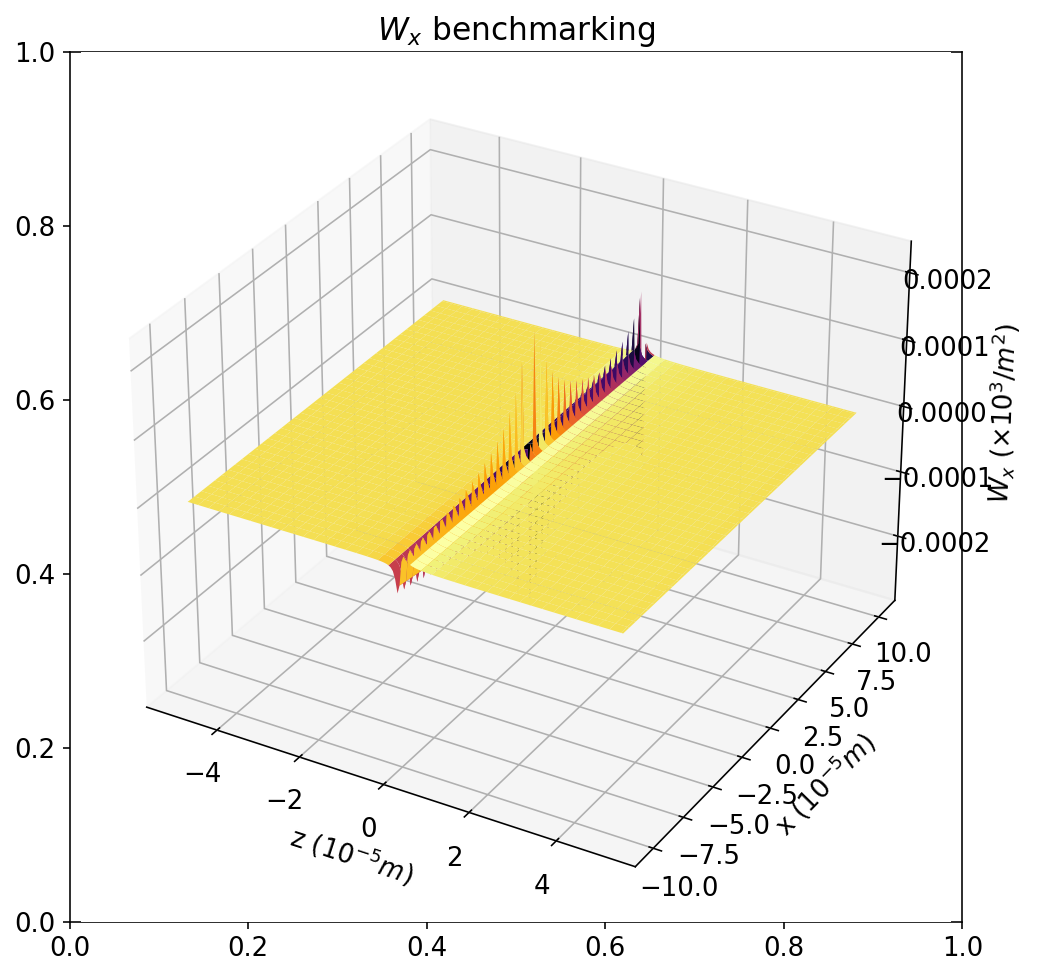

In [26]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, Es_case_B_grid_IGF, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

Text(0.5, 0.92, '$W_x$ benchmarking')

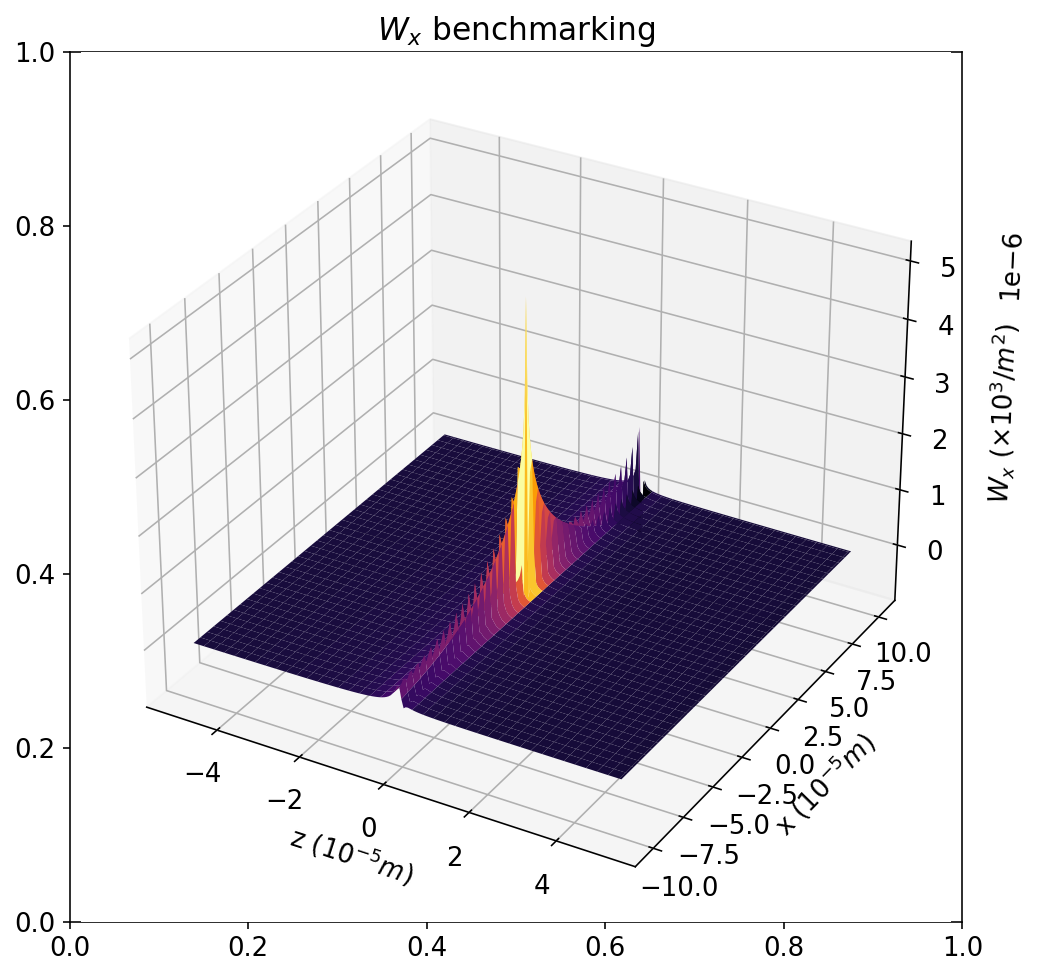

In [33]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, Fx_case_B_grid_IGF_Chris_no_nan , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

In [91]:
#lala = central_difference_z(psi_s_grid, 2*nz, 2*nx, dz, order=1)
#conv_s3 = fftconvolve2(lambda_grid_filtered, lala)[0]

In [34]:
conv_s3 = fftconvolve2(lambda_grid_filtered, Es_case_B_grid_IGF/dz/dx)[0]
conv_x3 = fftconvolve2(lambda_grid_filtered, Fx_case_B_grid_IGF_no_nan/dz/dx)[0]
conv_x3_Chris = fftconvolve2(lambda_grid_filtered, Fx_case_B_grid_IGF_Chris_no_nan/dz/dx)[0]

x_observe_index : 50


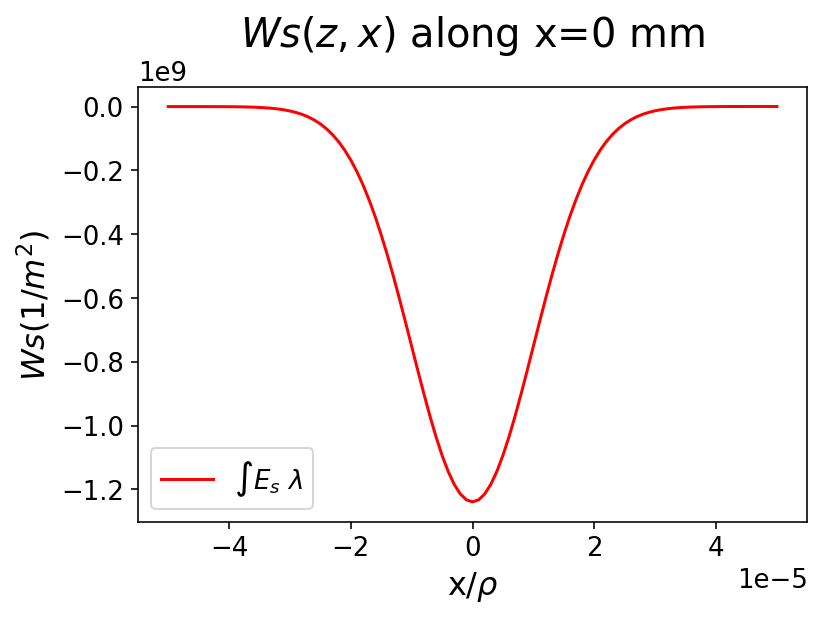

In [35]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s2[:,x_observe_index]* (dz * dx), label=r'$\int E_s ~ \lambda}$', c='red')

plt.xlabel(r'x/$\rho$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z,x)$ along x={x_observe} mm',  fontsize=20, pad=20)
plt.legend()

In [48]:
Fx_case_B(0, 1e-30,beta)

9.999959999999998e+29

In [89]:
Z0 = np.array([-5.00000000e-05, -4.92187500e-05, -4.84375000e-05, -4.76562500e-05,
       -4.68750000e-05, -4.60937500e-05, -4.53125000e-05, -4.45312500e-05,
       -4.37500000e-05, -4.29687500e-05, -4.21875000e-05, -4.14062500e-05,
       -4.06250000e-05, -3.98437500e-05, -3.90625000e-05, -3.82812500e-05,
       -3.75000000e-05, -3.67187500e-05, -3.59375000e-05, -3.51562500e-05,
       -3.43750000e-05, -3.35937500e-05, -3.28125000e-05, -3.20312500e-05,
       -3.12500000e-05, -3.04687500e-05, -2.96875000e-05, -2.89062500e-05,
       -2.81250000e-05, -2.73437500e-05, -2.65625000e-05, -2.57812500e-05,
       -2.50000000e-05, -2.42187500e-05, -2.34375000e-05, -2.26562500e-05,
       -2.18750000e-05, -2.10937500e-05, -2.03125000e-05, -1.95312500e-05,
       -1.87500000e-05, -1.79687500e-05, -1.71875000e-05, -1.64062500e-05,
       -1.56250000e-05, -1.48437500e-05, -1.40625000e-05, -1.32812500e-05,
       -1.25000000e-05, -1.17187500e-05, -1.09375000e-05, -1.01562500e-05,
       -9.37500000e-06, -8.59375000e-06, -7.81250000e-06, -7.03125000e-06,
       -6.25000000e-06, -5.46875000e-06, -4.68750000e-06, -3.90625000e-06,
       -3.12500000e-06, -2.34375000e-06, -1.56250000e-06, -7.81250000e-07,
        2.92755762e-20,  7.81250000e-07,  1.56250000e-06,  2.34375000e-06,
        3.12500000e-06,  3.90625000e-06,  4.68750000e-06,  5.46875000e-06,
        6.25000000e-06,  7.03125000e-06,  7.81250000e-06,  8.59375000e-06,
        9.37500000e-06,  1.01562500e-05,  1.09375000e-05,  1.17187500e-05,
        1.25000000e-05,  1.32812500e-05,  1.40625000e-05,  1.48437500e-05,
        1.56250000e-05,  1.64062500e-05,  1.71875000e-05,  1.79687500e-05,
        1.87500000e-05,  1.95312500e-05,  2.03125000e-05,  2.10937500e-05,
        2.18750000e-05,  2.26562500e-05,  2.34375000e-05,  2.42187500e-05,
        2.50000000e-05,  2.57812500e-05,  2.65625000e-05,  2.73437500e-05,
        2.81250000e-05,  2.89062500e-05,  2.96875000e-05,  3.04687500e-05,
        3.12500000e-05,  3.20312500e-05,  3.28125000e-05,  3.35937500e-05,
        3.43750000e-05,  3.51562500e-05,  3.59375000e-05,  3.67187500e-05,
        3.75000000e-05,  3.82812500e-05,  3.90625000e-05,  3.98437500e-05,
        4.06250000e-05,  4.14062500e-05,  4.21875000e-05,  4.29687500e-05,
        4.37500000e-05,  4.45312500e-05,  4.53125000e-05,  4.60937500e-05,
        4.68750000e-05,  4.76562500e-05,  4.84375000e-05,  4.92187500e-05,
        5.00000000e-05])

Wx0 = np.array([ 20924.1025531 ,  21292.69283807,  21675.07566734,  22072.64554097,
        22487.21221166,  22919.01062748,  23371.06883308,  23843.81093142,
        24338.99268096,  24856.05697075,  25404.77159184,  25976.98376743,
        26584.9350702 ,  27242.68762092,  27917.95683103,  28651.19870504,
        29446.0837835 ,  30258.85625712,  31175.32941465,  32167.02053868,
        33244.64913318,  34409.76693433,  35712.81653206,  37153.9554634 ,
        38708.38439955,  40443.1536767 ,  42336.32048817,  44500.61953054,
        46799.5942963 ,  49499.64654115,  52458.01837621,  55983.12795791,
        59310.7858697 ,  63329.82412636,  67871.78231555,  72914.4241459 ,
        78393.43259127,  84407.93747769,  90657.34087464,  97940.4537008 ,
       106517.9413773 , 113823.69399398, 122874.33235029, 131884.92786995,
       141707.7877252 , 151930.88900143, 163219.02483719, 174193.16405926,
       185572.50046693, 196721.05530785, 208640.23881089, 220144.12600383,
       230951.66772263, 242050.48447076, 252355.50489707, 261128.4628703 ,
       269568.94749835, 277846.65706682, 284353.18921842, 289432.2936765 ,
       292395.72803898, 295449.13714478, 296553.74854004, 297310.70138594,
       295349.77985956, 291846.39260125, 286245.8054862 , 281330.25150242,
       273053.28627802, 264380.67016792, 255103.49640236, 244189.91701775,
       232821.27413835, 220281.42887161, 209356.67454658, 195841.30088595,
       184065.02847913, 171084.14752474, 158796.53215527, 146517.29662253,
       135011.14604831, 123138.59119762, 112324.58210574, 102398.36169647,
        92381.5679822 ,  83703.27470694,  75263.16397172,  67359.02086651,
        60514.57860239,  54339.69685499,  48884.84235149,  43806.25303235,
        39281.74796551,  34911.29235508,  31676.93370473,  28604.21140844,
        25851.65485099,  23538.82074127,  21693.65748305,  19653.11134228,
        18204.20423414,  16882.84141304,  15791.63462842,  14725.51409413,
        13945.54481385,  13160.16335164,  12512.77875792,  11899.33412465,
        11414.5239908 ,  10978.22703782,  10572.66063214,  10241.66658078,
         9923.31131116,   9628.56745008,   9369.73696388,   9117.96295579,
         8892.40247908,   8687.17468172,   8485.36276988,   8302.15002451,
         8127.41943805,   7957.17286717,   7793.65613881,   7646.54110121,
         7501.06438303,   7362.87432124,   7229.12819513,   7101.32309252,
         6978.40537546])

x_observe_index : 50


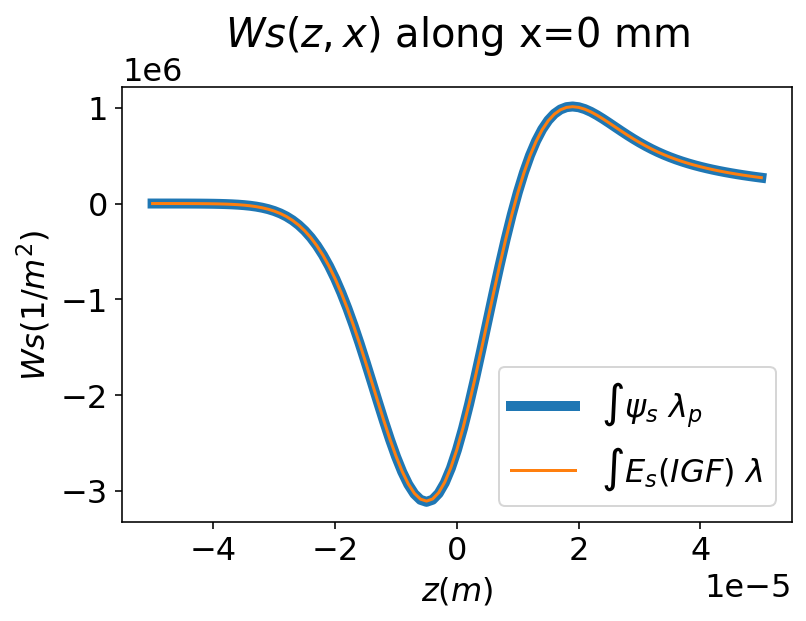

In [84]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s[:,x_observe_index]* (dz * dx), label=r'$\int \psi_s ~ \lambda_p}$',linewidth=5)
plt.plot(zvec, conv_s3[:,x_observe_index]* (dz * dx), label=r'$\int E_s(IGF) ~ \lambda}$')

plt.xlabel(r'$z(m)$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z,x)$ along x={x_observe} mm',  fontsize=20, pad=20)
plt.legend()

In [87]:
Z0, X0 = np.meshgrid(zvec, xvec, indexing='ij')

x_observe_index : 50


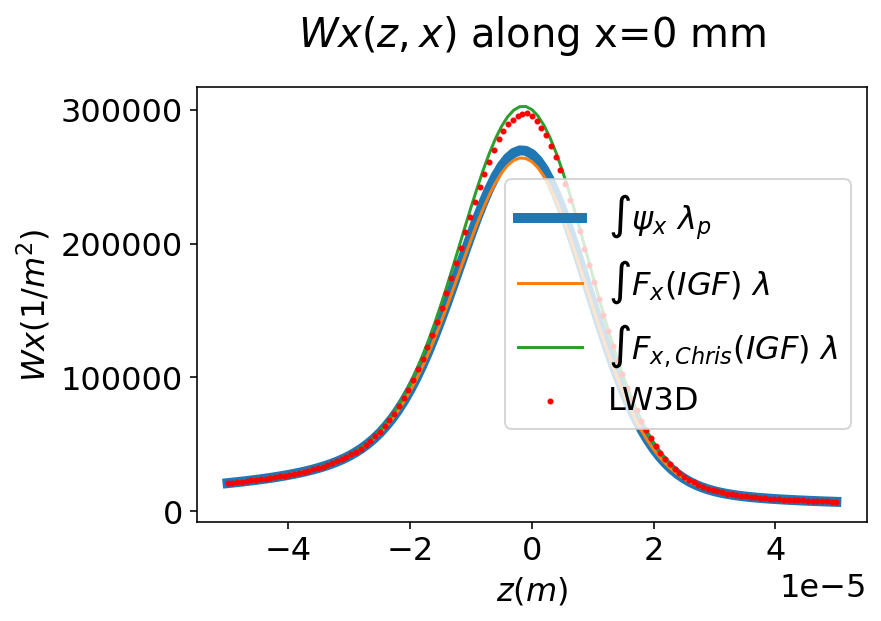

In [90]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_x[:,x_observe_index]* (dz * dx), label=r'$\int \psi_x ~ \lambda_p}$',linewidth=5)
plt.plot(zvec, conv_x3[:,x_observe_index]* (dz * dx), label=r'$\int F_x(IGF) ~ \lambda}$')
plt.plot(zvec, conv_x3_Chris[:,x_observe_index]* (dz * dx), label=r'$\int F_{x, Chris} (IGF) ~ \lambda}$')

plt.scatter(Z0,Wx0,c='red', zorder = 3, s=4, label='LW3D')

plt.xlabel(r'$z(m)$', fontsize=16)
plt.ylabel(r'$Wx (1/m^2)$', fontsize=16)
plt.title(fr'$Wx(z,x)$ along x={x_observe} mm',  fontsize=20, pad=20)
plt.legend()

In [32]:
conv_x3_Chris[50,50]* (dz * dx)

300107.4784288224

In [ ]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s[:,x_observe_index]* (dz * dx), label=r'$\int \psi_s ~ \lambda_p}$',linewidth=5)
plt.plot(zvec, conv_s4[:,x_observe_index]* (dz * dx), label=r'$\int E_s(IGF) ~ \lambda}$')

plt.xlabel(r'x/$\rho$', fontsize=16)
plt.ylabel(r'$Ws (1/m^2)$', fontsize=16)
plt.title(fr'$Ws(z,x)$ along x={x_observe} mm',  fontsize=20, pad=20)
plt.legend()

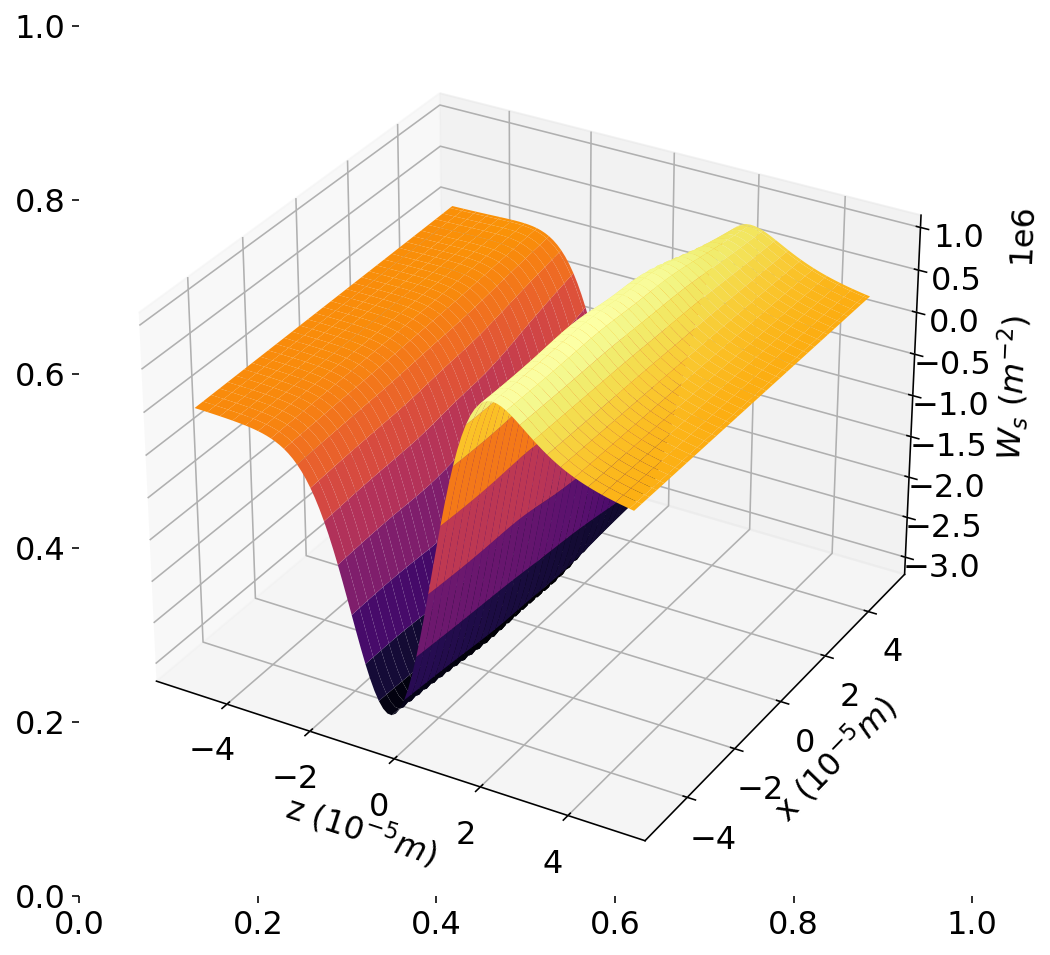

In [93]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
plt.box(False)
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, conv_s*dz*dx , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_s$ $(m^{-2})$ ')
ax.zaxis.labelpad = 10
#ax.set_title(r'$W_x$ benchmarking')

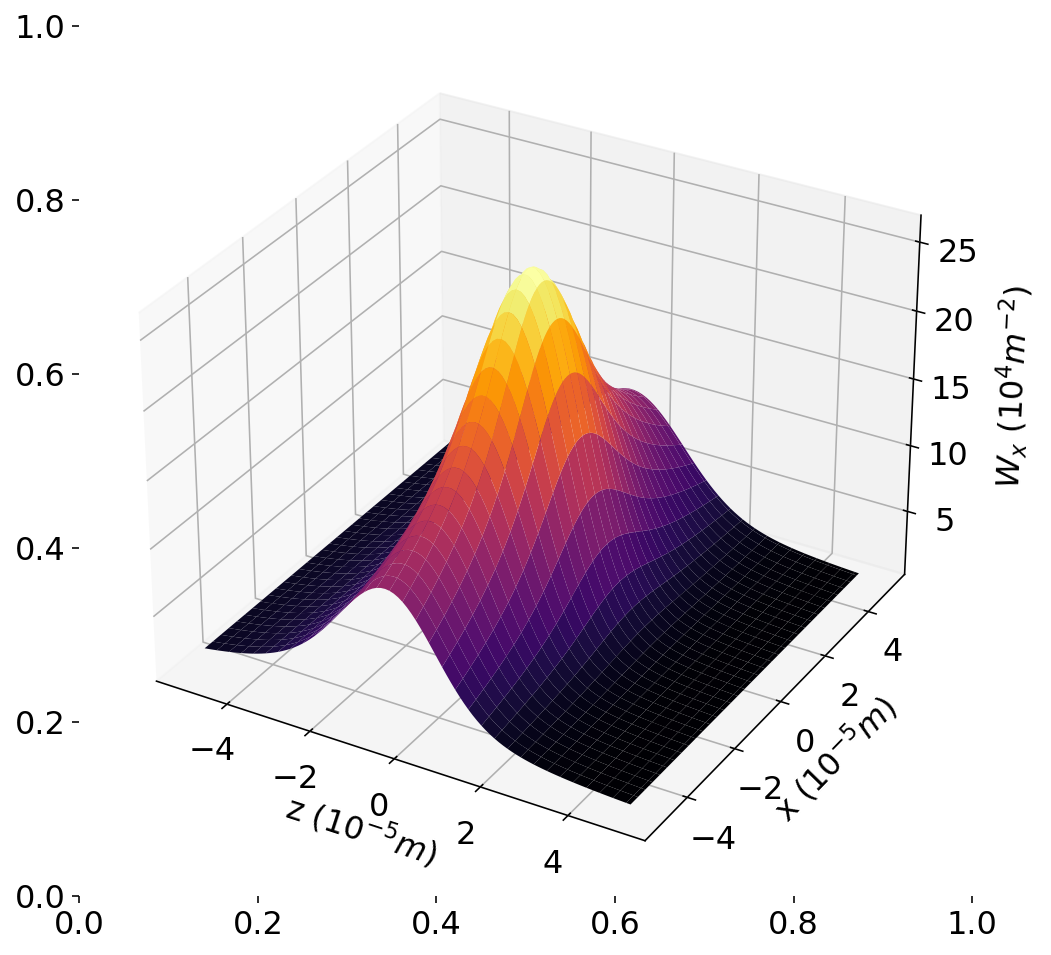

In [103]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
plt.box(False)
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, conv_x3*dz*dx/10000 , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(10^4 m^{-2})$ ')
ax.zaxis.labelpad = 10
#ax.set_title(r'$W_x$ benchmarking')

In [75]:
diff = np.abs(conv_s-conv_s3)*dz*dx

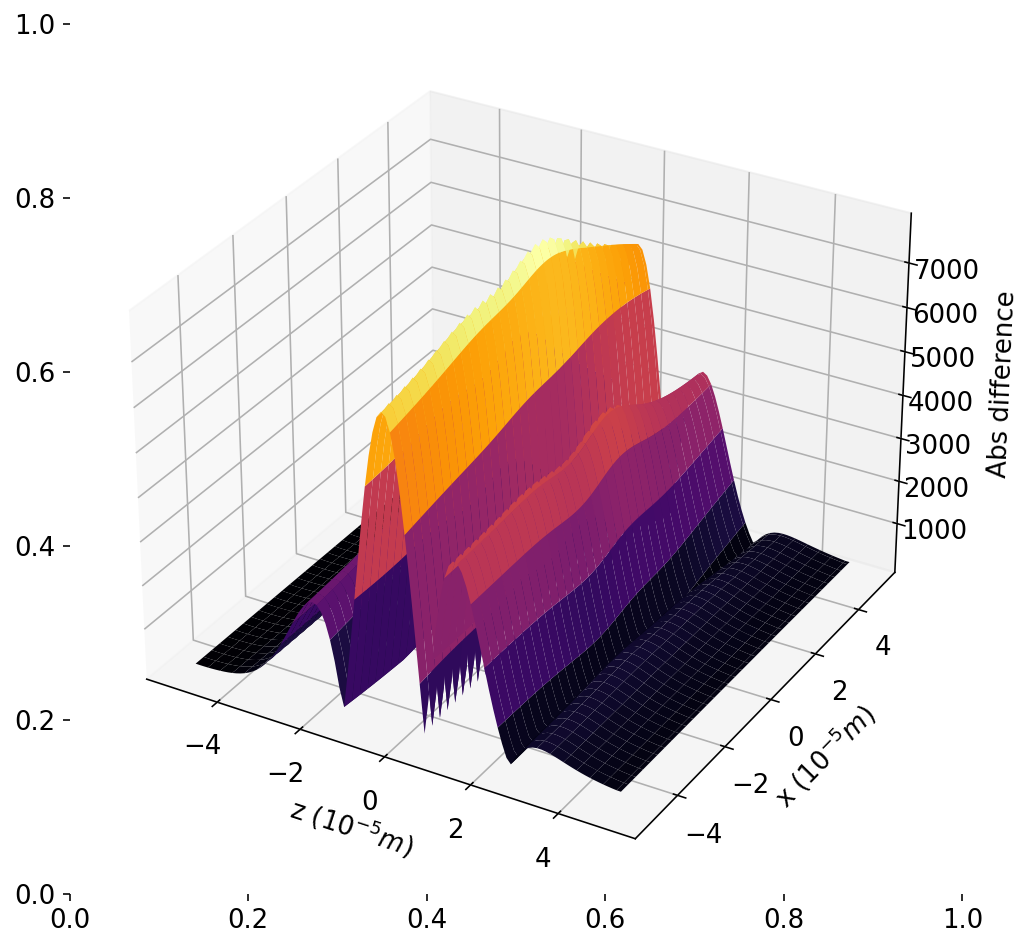

In [77]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
plt.box(False)
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, diff, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'Abs difference')
ax.zaxis.labelpad = 10
#ax.set_title(r'$W_x$ benchmarking')

In [97]:
lala = central_difference_z(psi_s_grid, 2*nz, 2*nx, dz, order=1)

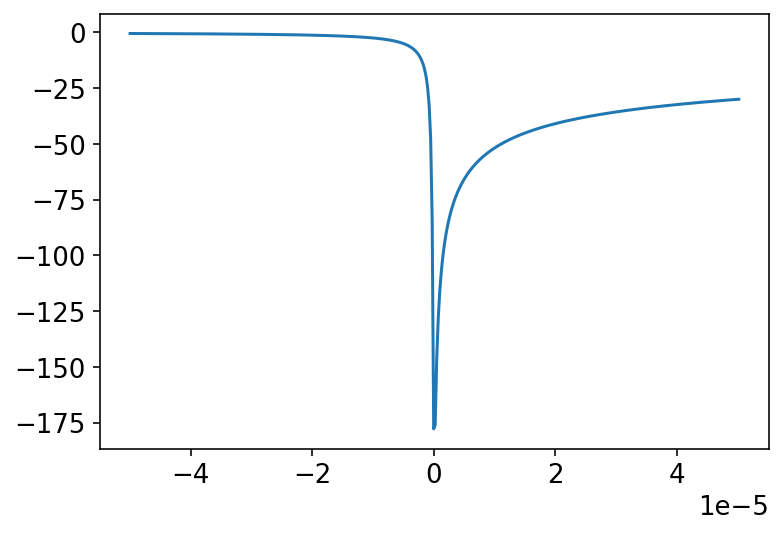

In [98]:
plt.plot(zvec2, psi_s_grid[:,x_observe_index])

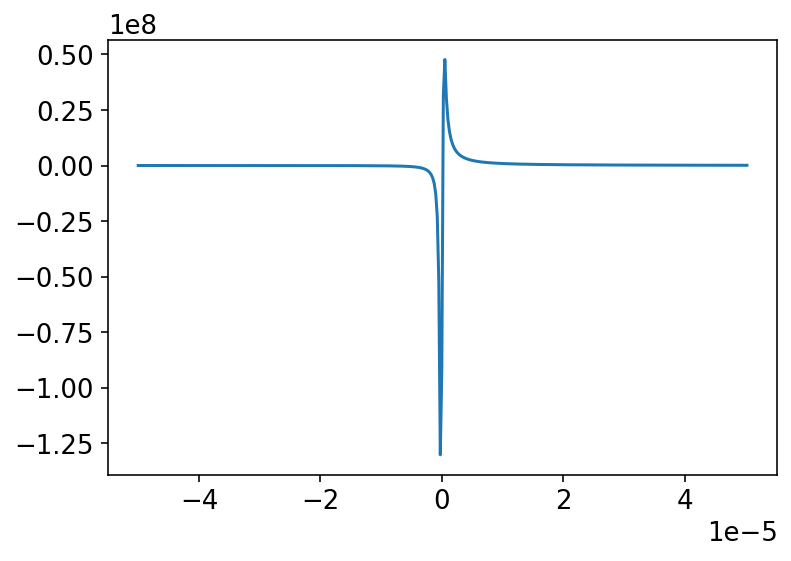

In [99]:
plt.plot(zvec2, lala[:,x_observe_index])

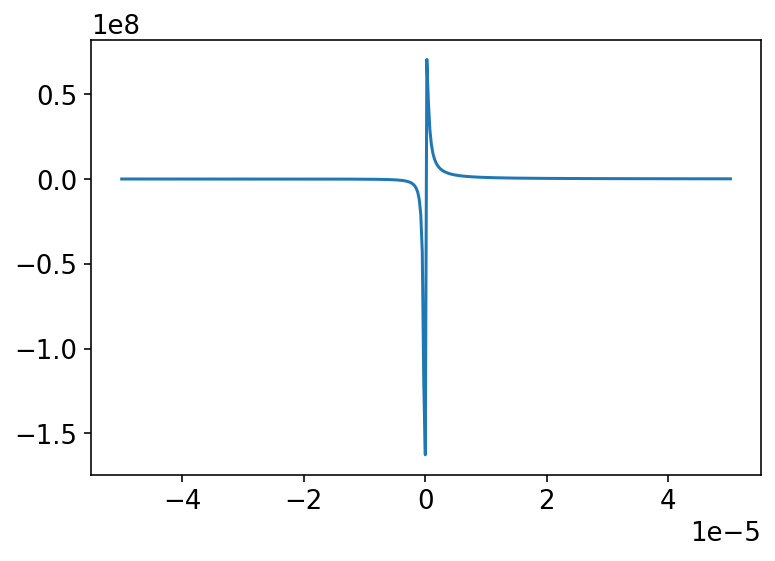

In [100]:
plt.plot(zvec2, Es_case_B_grid[:,x_observe_index])

In [102]:
conv_s3 = fftconvolve2(lambda_grid_filtered, lala)[0]

x_observe_index : 100


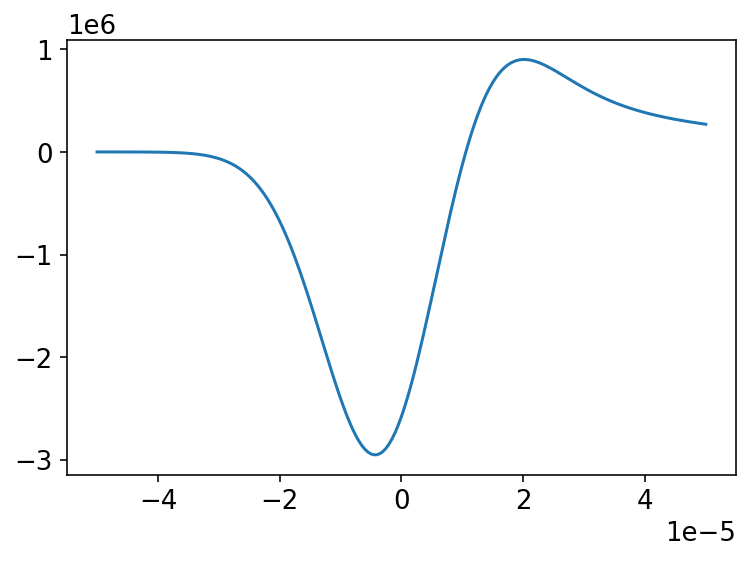

In [103]:
x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )
plt.plot(zvec, conv_s3[:,x_observe_index]* (dz * dx))

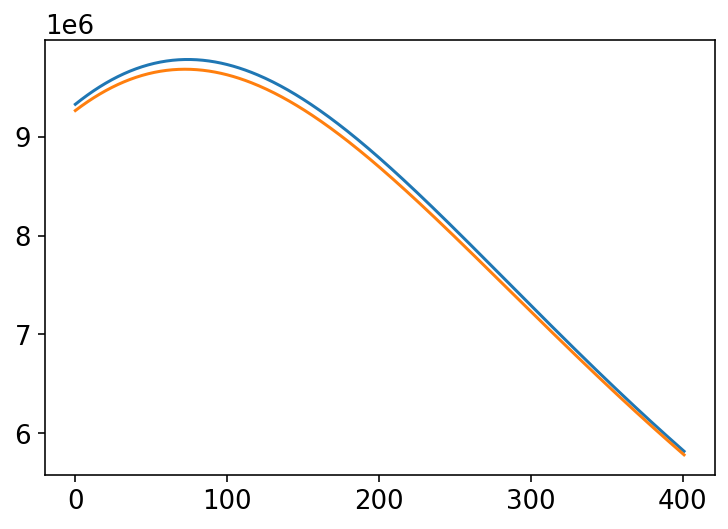

In [127]:
plt.plot(lala[207,:])
plt.plot(Es_case_B_grid[207,:])

In [146]:
zvec2[201]

2.5e-07

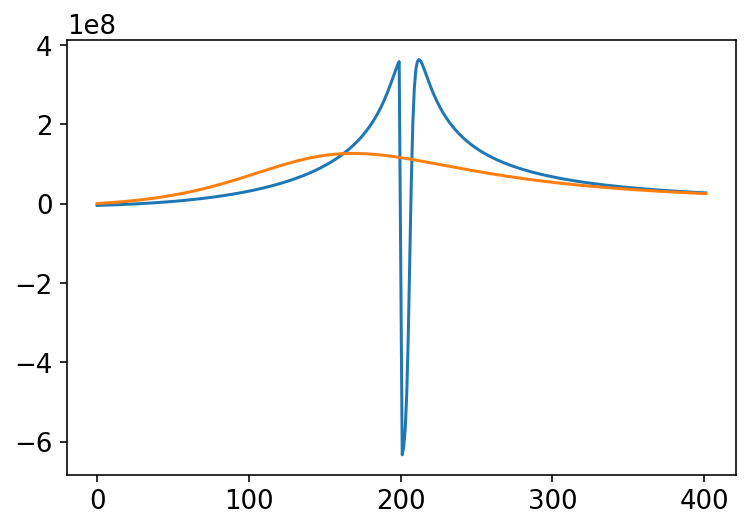

In [147]:
plt.plot(lala[201,:])
plt.plot(Es_case_B_grid[201,:])
#plt.yscale('log')

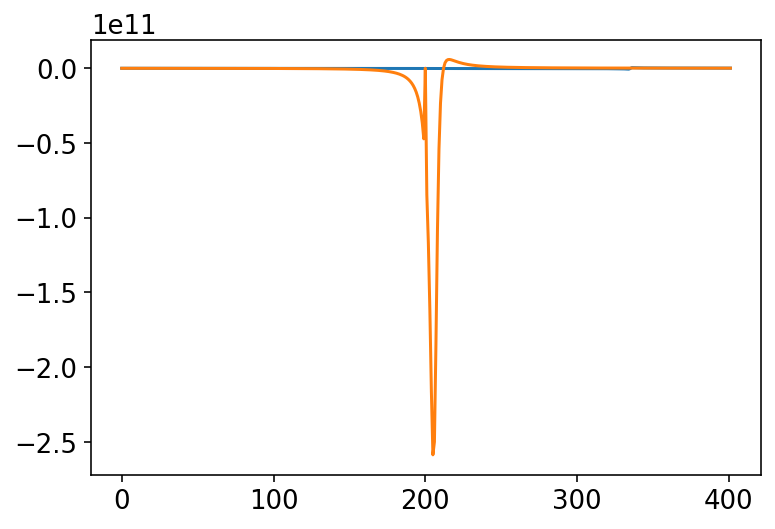

In [133]:
plt.plot(lala[200,:])
plt.plot(Es_case_B_grid[200,:])

In [142]:
from csr2d.core2 import alpha_exact_case_B_brentq
from csr2d.core2 import alpha

In [143]:
alpha(0,0,beta)

0.0

Text(0.5, 0.92, 'Es(z,x) Case B')

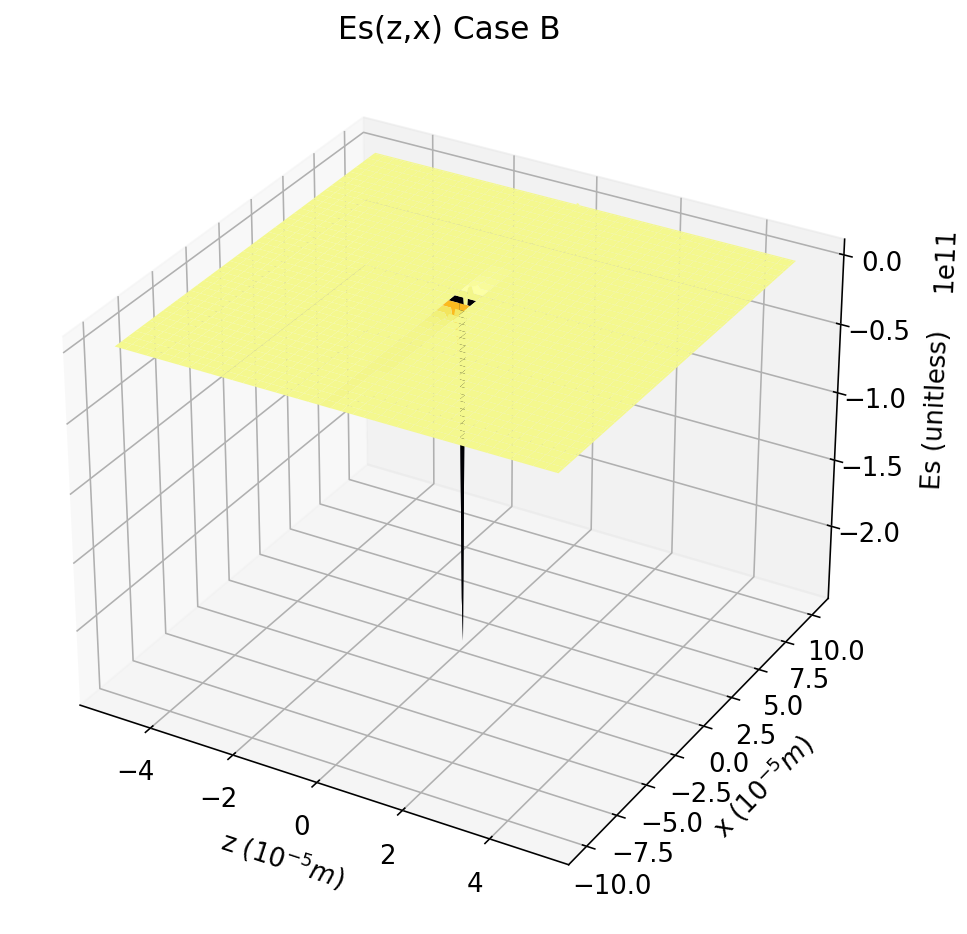

In [101]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, Es_case_B_grid , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$', labelpad = 6)
ax.set_ylabel(r'x $(10^{-5}m)$', labelpad = 6)
ax.set_zlabel(r'Es (unitless)')
ax.zaxis.labelpad = 10
ax.set_title(r'Es(z,x) Case B')

Text(0.5, 0.92, 'Es(z,x) quad_IGF Case B')

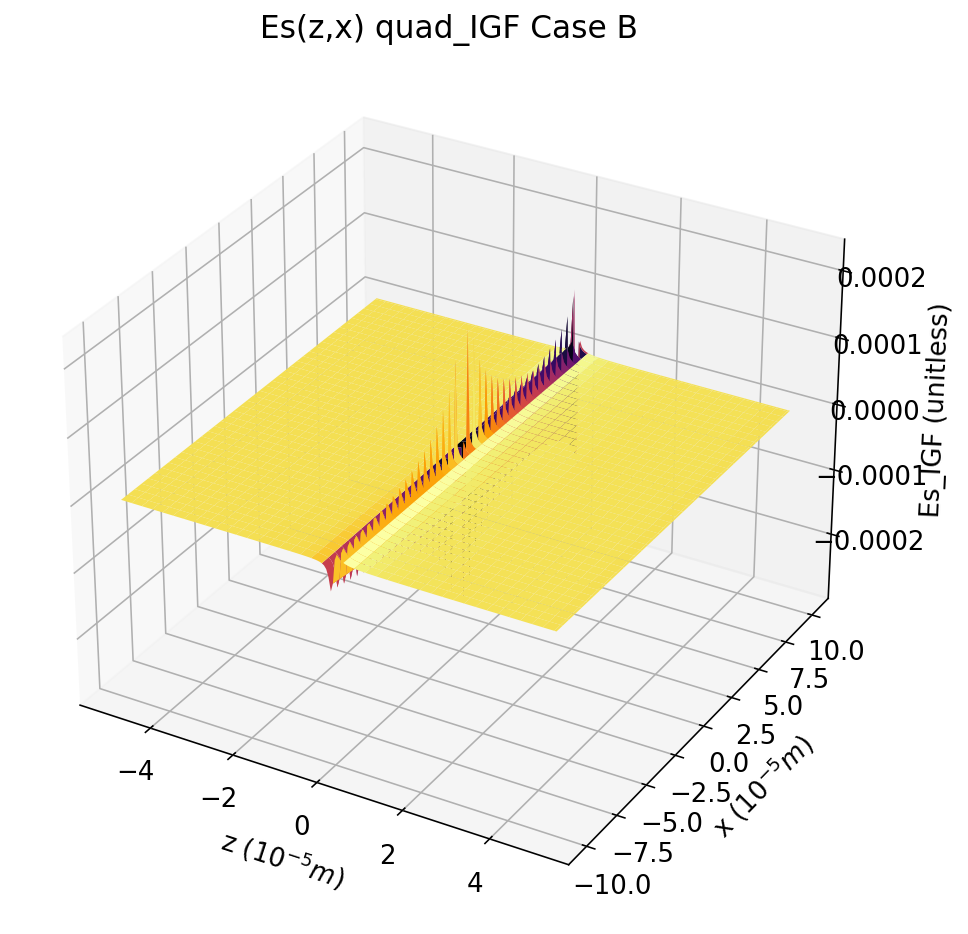

In [105]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, Es_case_B_grid_IGF , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$', labelpad = 6)
ax.set_ylabel(r'x $(10^{-5}m)$', labelpad = 6)
ax.set_zlabel(r'Es_IGF (unitless)', labelpad = 10)
ax.zaxis.labelpad = 10
ax.set_title(r'Es(z,x) quad_IGF Case B')

Text(0.5, 0.92, '$W_x$ benchmarking')

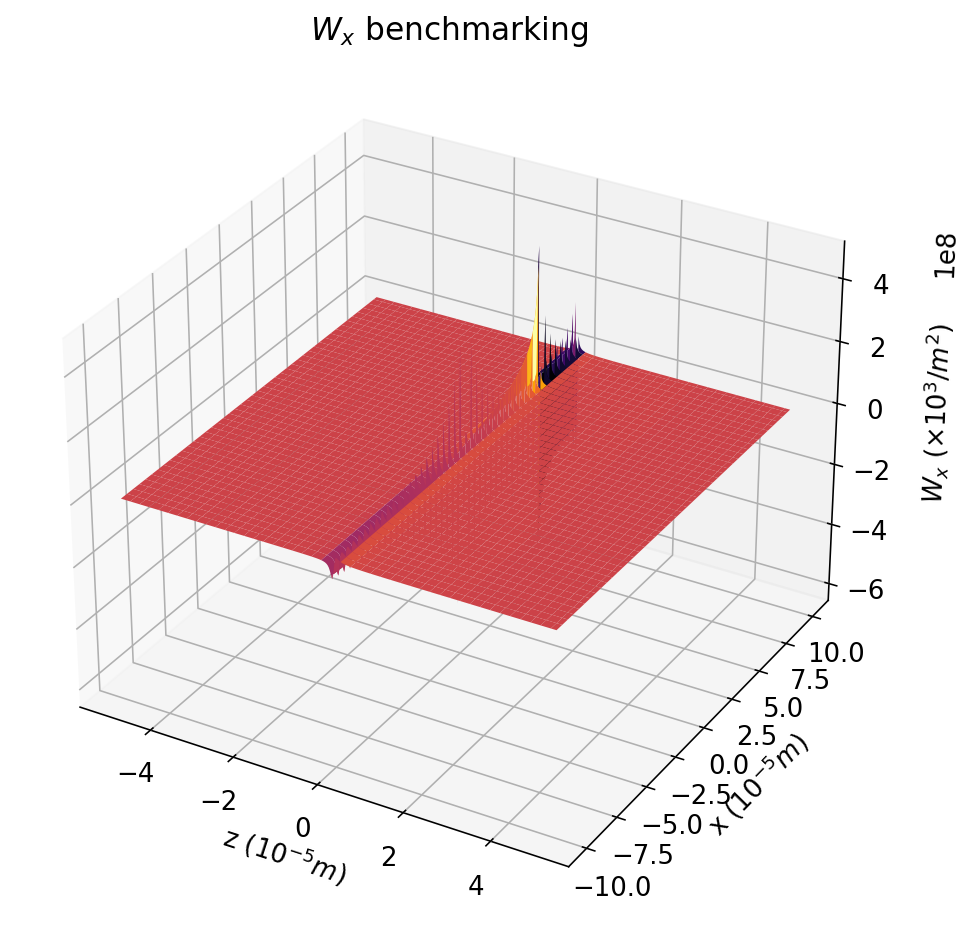

In [108]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, lala , cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

Text(0.5, 0.92, '$W_x$ benchmarking')

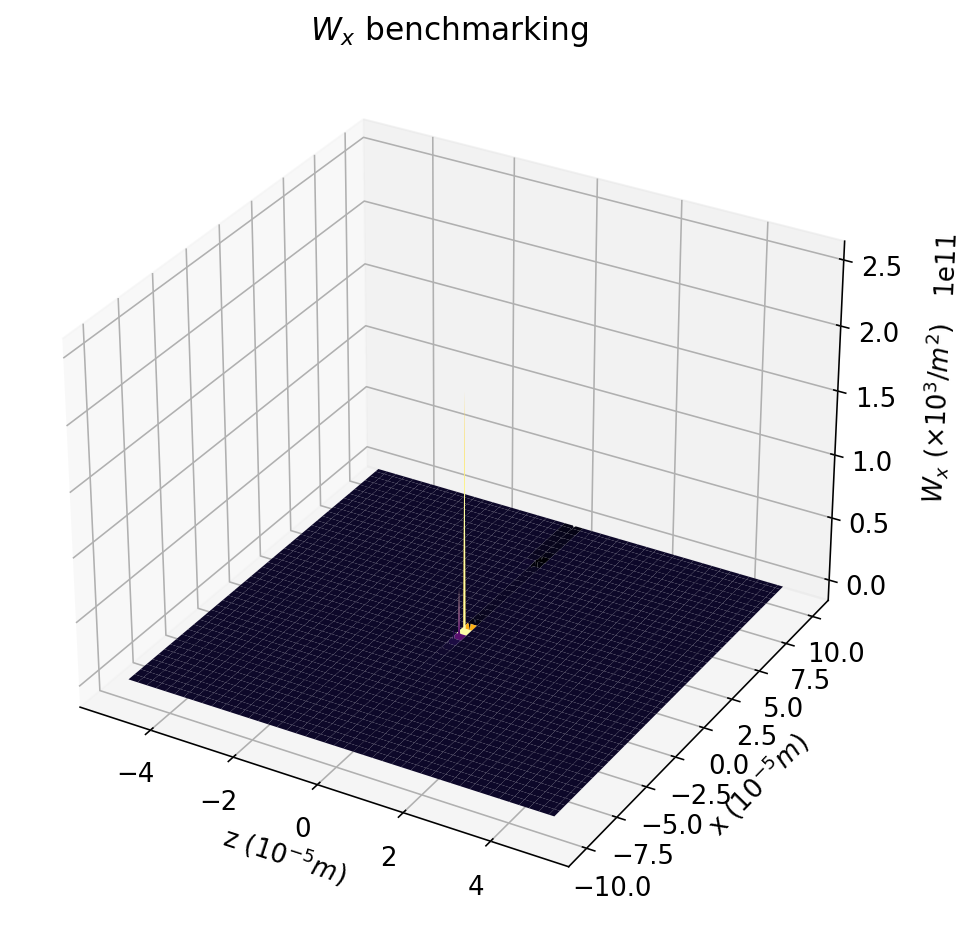

In [109]:
from mpl_toolkits import mplot3d
Z2, X2 = np.meshgrid(zvec2, xvec2, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z2*1e5, X2*1e5, lala - Es_case_B_grid, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

Text(0.5, 1.0, 'Wx(z) along x=0 mm')

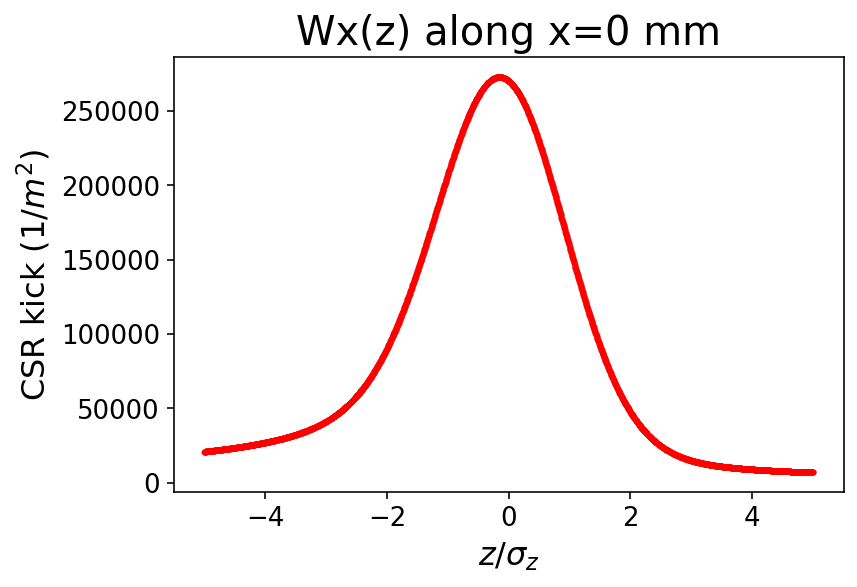

In [12]:
plt.scatter(zvec/sigma_z, Wx_grid[:,x_observe_index], color='red', label='$\phi$=', zorder=10, s=4)

plt.xlabel(r'$z/\sigma_z$', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)

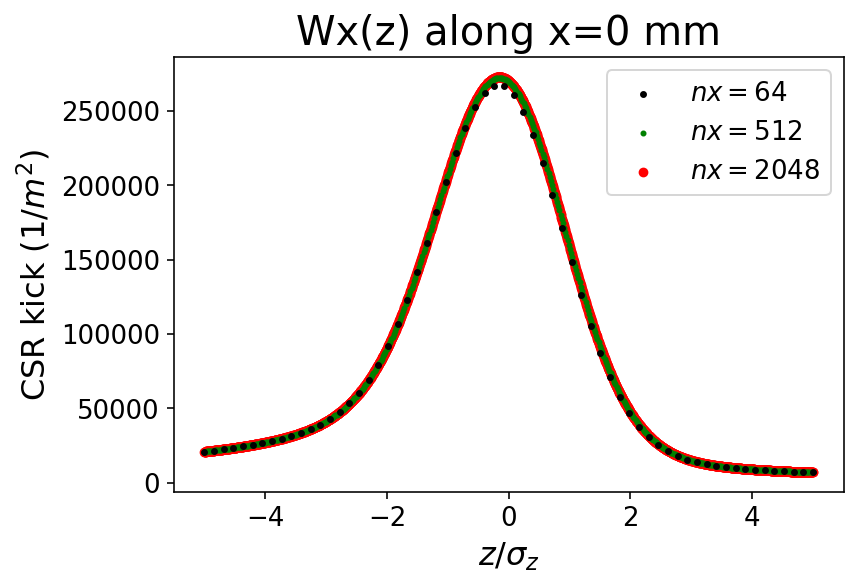

In [67]:
#plt.scatter(zvec_64/sigma_z, Wx_x0_64, color='black', label='$nx=64$', zorder=20, s=6)
#plt.scatter(zvec_512/sigma_z, Wx_x0_512, color='green', label='$nx=512$', zorder=15, s=4)
#plt.scatter(zvec_2048/sigma_z, Wx_x0_2048, color='red', label='$nx=2048$', zorder=10, s=15)


#plt.xlabel(r'$z/\sigma_z$', fontsize=16)
#plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
#plt.title('Wx(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
#plt.legend()

In [69]:
# Save the beam if needed
#haha = np.array(list(zip(zvec_2048/sigma_z,Wx_x0_2048)))
#np.savetxt("Wx_no_phi_Chris_parameter_nx2048.dat",haha)

Text(0.5, 0.92, '$W_x$ benchmarking')

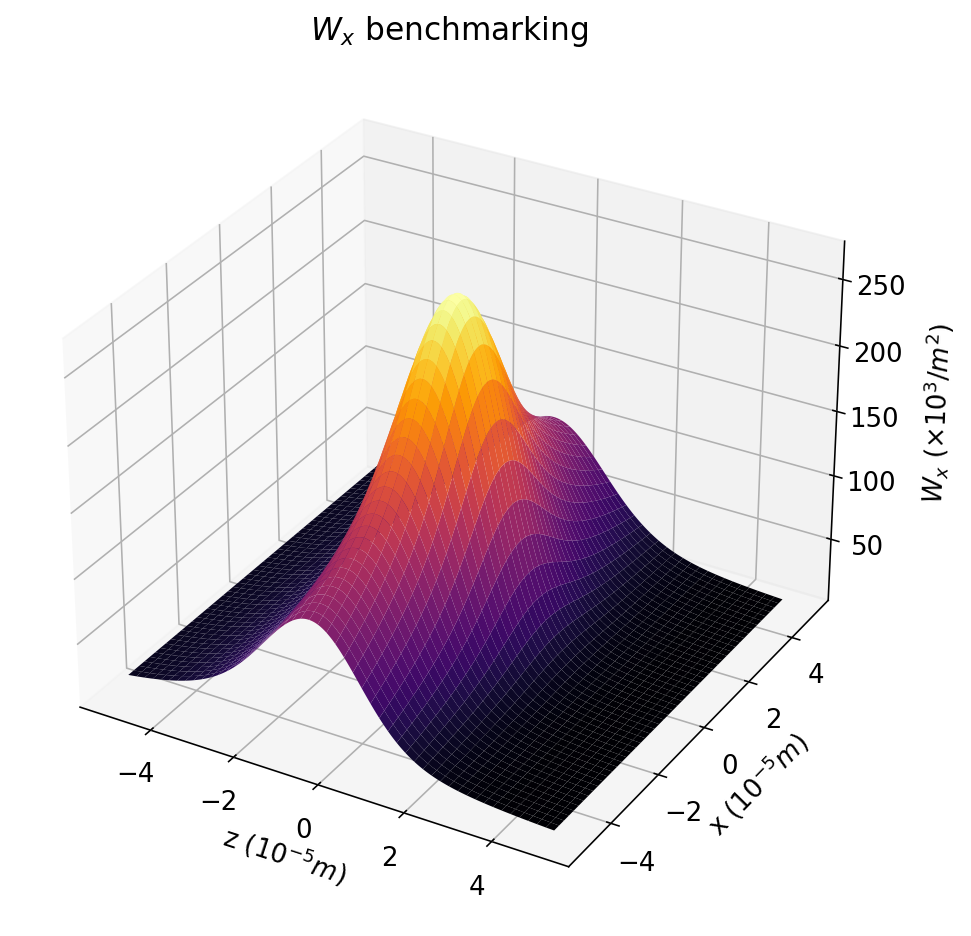

In [13]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Wx_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
#zline = np.linspace(min(zvec), max(zvec), 1000)
#xline = np.zeros(len(zline))
#fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
#ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

#ax.azim = 90

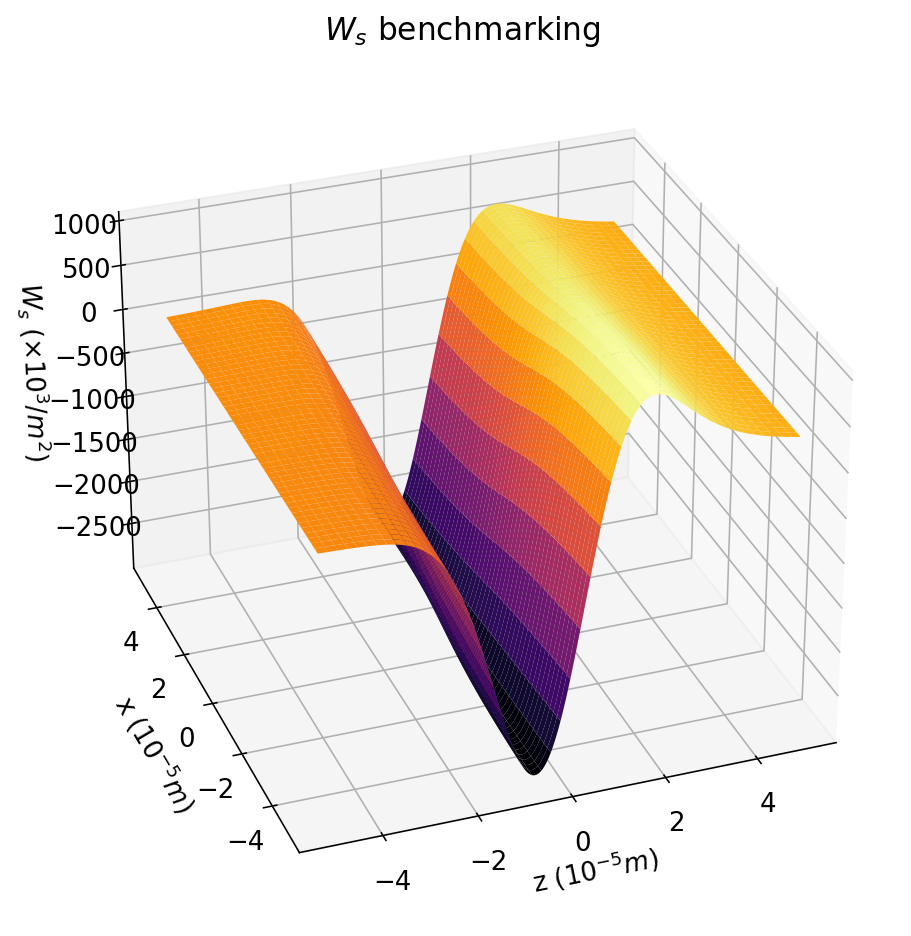

In [14]:
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Ws_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
#zline = np.linspace(min(zvec), max(zvec), 1000)
#xline = np.zeros(len(zline))
#fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
#ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_s$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_s$ benchmarking')

ax.azim = 250

# Checking the root finder

In [1]:
from csr2d.core2 import alpha_exact, alpha_exact_case_B_brentq

In [33]:
gamma = 500
beta = (1-1/gamma**2)**(1/2)

nz = 250
nx = 250

sigma_x  = 10e-6
sigma_z  = 10e-6

zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')


In [34]:
# Can be slow ( not jitted )
aa = alpha_exact(zm, xm, beta)

In [35]:
aa_brentq = alpha_exact_case_B_brentq(zm, xm, beta)

In [71]:
diff = np.abs(( aa_brentq - aa)/aa) * 100

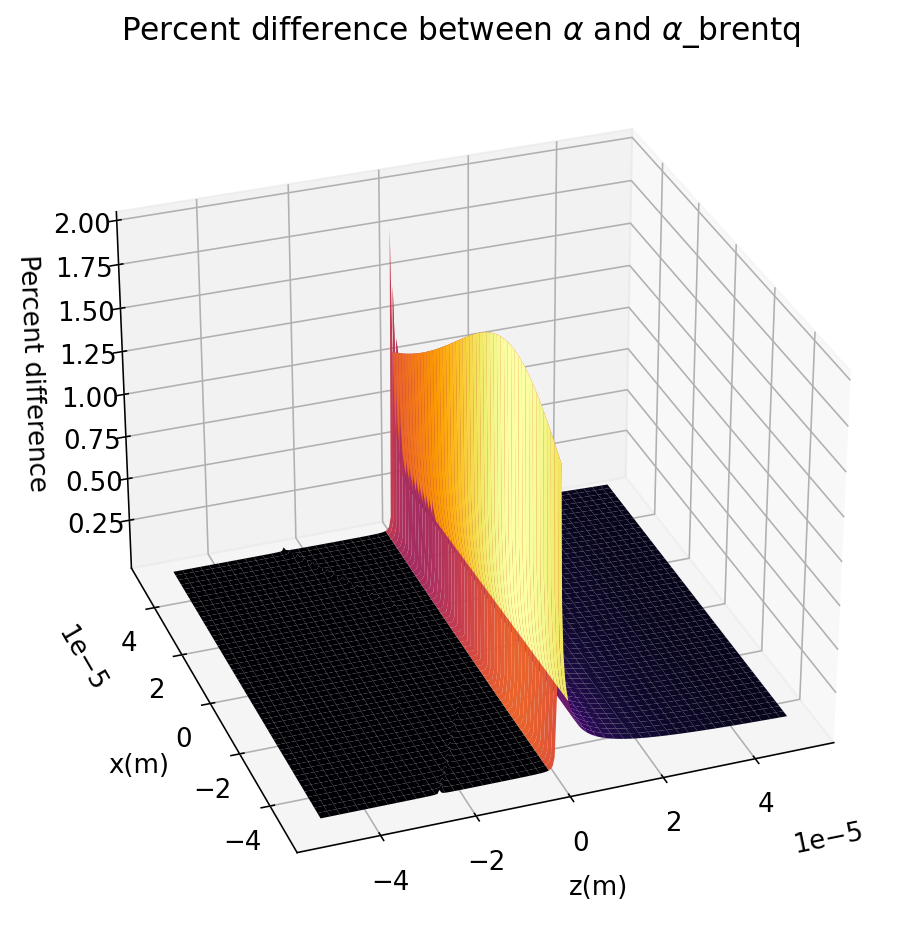

In [72]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm, xm, diff, cmap='inferno', zorder=1)


ax.set_xlabel(r'z(m)', labelpad = 10)
ax.set_ylabel(r'x(m)', labelpad = 10)
ax.set_zlabel(r'Percent difference', labelpad = 18)
ax.zaxis.labelpad = 10
ax.set_title(r'Percent difference between $\alpha$ and $\alpha$_brentq')

ax.azim = 250

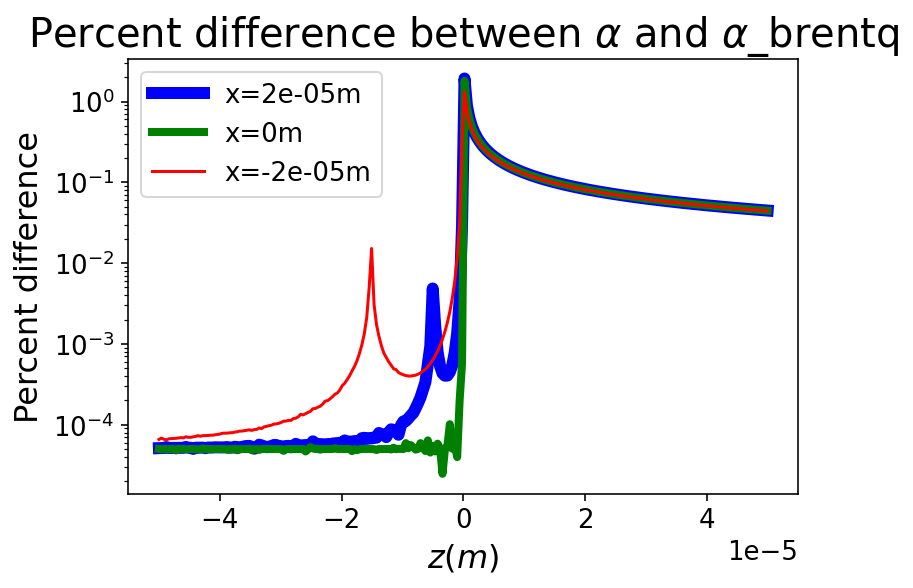

In [73]:
x_o = 2*sigma_x
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, 100], label= f'x={x_o}m', c='blue', linewidth=6)
plt.yscale('log')

x_o = 0
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, xix], label= f'x={x_o}m', c='green', linewidth=4)


x_o = -2*sigma_x
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, 200], label= f'x={x_o}m', c='red')

plt.xlabel(r'$z(m)$', fontsize=16)
plt.ylabel('Percent difference', fontsize=16)
plt.title(r'Percent difference between $\alpha$ and $\alpha$_brentq',  fontsize=20)
plt.legend()

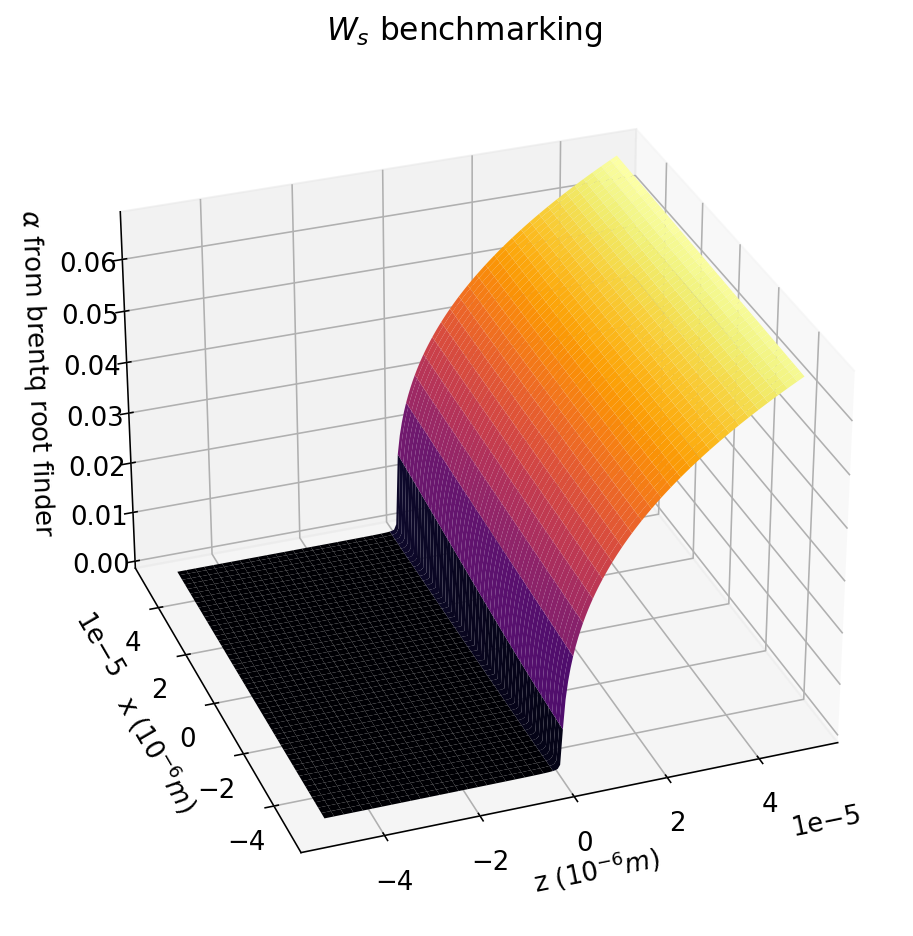

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm, xm, aa, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-6}m)$')
ax.set_ylabel(r'x $(10^{-6}m)$')
ax.set_zlabel(r'$\alpha$ from brentq root finder ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_s$ benchmarking')

ax.azim = 250

In [ ]:
from scipy.ndimage import map_coordinates
map_coordinates(Ws_grid, np.array([zcoord, xcoord]), order=2)

In [1]:
from fast_interp import interp2d
import numpy as np

nx = 50
ny = 37
xv, xh = np.linspace(0, 1,       nx, endpoint=True,  retstep=True)
yv, yh = np.linspace(0, 2*np.pi, ny, endpoint=False, retstep=True)
x, y = np.meshgrid(xv, yv, indexing='ij')

test_function = lambda x, y: np.exp(x)*np.exp(np.sin(y))
f = test_function(x, y)
test_x = -xh/2.0
test_y = 271.43
fa = test_function(test_x, test_y)

interpolater = interp2d([0,0], [1,2*np.pi], [xh,yh], f, k=5, p=[False,True], e=[1,0])
fe = interpolater(test_x, test_y)

print('Error is: {:0.2e}'.format(np.abs(fe-fa)))

/global/homes/w/wlou1991/.conda/envs/cupy/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k5'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../GitHub/fast_interp/fast_interp/fast_interp.py", line 385:
@numba.njit(parallel=True)
def _interp2d_k5(f, xout, yout, fout, a, h, n, p, o, lb, ub):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/global/homes/w/wlou1991/.conda/envs/cupy/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'h' of function '_interp2d_k5'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprec

Error is: 4.53e-06
